In [1]:
import pandas as pd
import numpy as np
import plotly.express as px 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore') 

In [2]:
df = pd.read_csv("CDC.csv")
pd.set_option('display.max_columns', 25)
df.head()

,cpsc_case_number,narrative,treatment_date,age,sex,race,other_race,hispanic,diagnosis,other_diagnosis,diagnosis_2,other_diagnosis_2,body_part,body_part_2,disposition,location,fire_involvement,alcohol,drug,product_1,product_2,product_3
0,190103269,94YOM FELL TO THE FLOOR AT THE NURSING HOME ON...,2019-01-01,94,1,0,NaN,0,62,NaN,NaN,NaN,75,NaN,4,5,0,0,0,1807,0,0
1,190103270,86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED...,2019-01-01,86,1,0,NaN,0,62,NaN,NaN,NaN,75,NaN,4,1,0,0,0,611,0,0
2,190103273,87YOF WAS GETTING UP FROM THE COUCH AND FELL T...,2019-01-01,87,2,0,NaN,0,53,NaN,NaN,NaN,32,NaN,4,1,0,0,0,679,1807,0
3,190103291,67YOF WAS AT A FRIENDS HOUSE AND SLIPPED ON WA...,2019-01-01,67,2,0,NaN,0,57,NaN,NaN,NaN,33,NaN,1,1,0,0,0,1807,0,0
4,190103294,70YOF WAS STANDING ON A STEP STOOL AND FELL OF...,2019-01-01,70,2,0,NaN,0,57,NaN,NaN,NaN,33,NaN,1,1,0,0,0,620,0,0


In [3]:
df.shape

(115128, 22)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115128 entries, 0 to 115127
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   cpsc_case_number   115128 non-null  int64  
 1   narrative          115128 non-null  object 
 2   treatment_date     115128 non-null  object 
 3   age                115128 non-null  int64  
 4   sex                115128 non-null  int64  
 5   race               115128 non-null  int64  
 6   other_race         1022 non-null    object 
 7   hispanic           115128 non-null  int64  
 8   diagnosis          115128 non-null  int64  
 9   other_diagnosis    2522 non-null    object 
 10  diagnosis_2        43145 non-null   float64
 11  other_diagnosis_2  4978 non-null    object 
 12  body_part          115128 non-null  int64  
 13  body_part_2        43145 non-null   float64
 14  disposition        115128 non-null  int64  
 15  location           115128 non-null  int64  
 16  fi

In [5]:
df.describe()

,cpsc_case_number,age,sex,race,hispanic,diagnosis,diagnosis_2,body_part,body_part_2,disposition,location,fire_involvement,alcohol,drug,product_1,product_2,product_3
count,1.151280e+05,115128.000000,115128.000000,115128.000000,115128.000000,115128.000000,43145.000000,115128.000000,43145.000000,115128.000000,115128.000000,115128.000000,115128.000000,115128.000000,115128.000000,115128.000000,115128.000000
mean,2.081887e+08,79.354814,1.631158,0.795688,1.258634,58.685871,59.799815,65.514983,63.976799,2.122099,1.714691,0.000599,0.022479,0.040346,2167.772167,504.121899,56.160908
std,1.179966e+07,8.877289,0.482493,0.757864,0.949793,4.179401,6.198700,20.067912,21.981593,1.481016,1.950247,0.038535,0.148237,0.196771,1208.341005,1020.819964,373.597546
min,1.901033e+08,65.000000,1.000000,0.000000,0.000000,42.000000,41.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,110.000000,0.000000,0.000000
25%,2.002557e+08,72.000000,1.000000,0.000000,0.000000,57.000000,53.000000,37.000000,35.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1715.000000,0.000000,0.000000
50%,2.105278e+08,79.000000,2.000000,1.000000,2.000000,57.000000,59.000000,75.000000,75.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1807.000000,0.000000,0.000000
75%,2.204607e+08,86.000000,2.000000,1.000000,2.000000,62.000000,63.000000,79.000000,79.000000,4.000000,1.000000,0.000000,0.000000,0.000000,3299.000000,474.750000,0.000000
max,2.302226e+08,112.000000,2.000000,6.000000,2.000000,74.000000,74.000000,94.000000,94.000000,6.000000,9.000000,3.000000,1.000000,1.000000,5043.000000,5040.000000,5040.000000


In [6]:
df.isnull().sum()

cpsc_case_number          0
narrative                 0
treatment_date            0
age                       0
sex                       0
race                      0
other_race           114106
hispanic                  0
diagnosis                 0
other_diagnosis      112606
diagnosis_2           71983
other_diagnosis_2    110150
body_part                 0
body_part_2           71983
disposition               0
location                  0
fire_involvement          0
alcohol                   0
drug                      0
product_1                 0
product_2                 0
product_3                 0
dtype: int64

In [7]:
df.duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
115123    False
115124    False
115125    False
115126    False
115127    False
Length: 115128, dtype: bool

no duplicated values

In [9]:
import json
from pathlib import Path


## load variable mapping

In [10]:
with Path("variable_mapping.json").open("r") as f:
    mapping = json.load(f, parse_int=True)

In [11]:
# convert the encoded values in the mapping to integers since they get read in as strings
for c in mapping.keys():
    mapping[c] = {int(k): v for k, v in mapping[c].items()}

In [12]:
# the keys in the dictionary correspond to columns in the primary (and supplementary) data
mapping.keys()

dict_keys(['sex', 'race', 'hispanic', 'alcohol', 'drug', 'body_part', 'body_part_2', 'diagnosis', 'diagnosis_2', 'disposition', 'location', 'fire_involvement', 'product_1', 'product_2', 'product_3'])

In [13]:
# mapping for 'sex' column
mapping["sex"]

{0: 'UNKNOWN', 1: 'MALE', 2: 'FEMALE', 3: 'NON-BINARY/OTHER'}

## load primary data

In [14]:
df = pd.read_csv(
    "primary_data.csv",
    # set columns that can be null to nullable ints
    dtype={"body_part_2": "Int64", "diagnosis_2": "Int64"},
)
df.head()

,cpsc_case_number,narrative,treatment_date,age,sex,race,other_race,hispanic,diagnosis,other_diagnosis,diagnosis_2,other_diagnosis_2,body_part,body_part_2,disposition,location,fire_involvement,alcohol,drug,product_1,product_2,product_3
0,190103269,94YOM FELL TO THE FLOOR AT THE NURSING HOME ON...,2019-01-01,94,1,0,NaN,0,62,NaN,<NA>,NaN,75,<NA>,4,5,0,0,0,1807,0,0
1,190103270,86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED...,2019-01-01,86,1,0,NaN,0,62,NaN,<NA>,NaN,75,<NA>,4,1,0,0,0,611,0,0
2,190103273,87YOF WAS GETTING UP FROM THE COUCH AND FELL T...,2019-01-01,87,2,0,NaN,0,53,NaN,<NA>,NaN,32,<NA>,4,1,0,0,0,679,1807,0
3,190103291,67YOF WAS AT A FRIENDS HOUSE AND SLIPPED ON WA...,2019-01-01,67,2,0,NaN,0,57,NaN,<NA>,NaN,33,<NA>,1,1,0,0,0,1807,0,0
4,190103294,70YOF WAS STANDING ON A STEP STOOL AND FELL OF...,2019-01-01,70,2,0,NaN,0,57,NaN,<NA>,NaN,33,<NA>,1,1,0,0,0,620,0,0


## replace numeric values with corresponding strings


In [15]:
df = df.copy()

for col in mapping.keys():
    df[col] = df[col].map(mapping[col])


In [16]:
df.head()

,cpsc_case_number,narrative,treatment_date,age,sex,race,other_race,hispanic,diagnosis,other_diagnosis,diagnosis_2,other_diagnosis_2,body_part,body_part_2,disposition,location,fire_involvement,alcohol,drug,product_1,product_2,product_3
0,190103269,94YOM FELL TO THE FLOOR AT THE NURSING HOME ON...,2019-01-01,94,MALE,N.S.,NaN,Unk/Not stated,62 - INTERNAL INJURY,NaN,NaN,NaN,75 - HEAD,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,PUBLIC,NO/?,No/Unk,No/Unk,1807 - FLOORS OR FLOORING MATERIALS,0 - None,0 - None
1,190103270,86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED...,2019-01-01,86,MALE,N.S.,NaN,Unk/Not stated,62 - INTERNAL INJURY,NaN,NaN,NaN,75 - HEAD,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/?,No/Unk,No/Unk,611 - BATHTUBS OR SHOWERS,0 - None,0 - None
2,190103273,87YOF WAS GETTING UP FROM THE COUCH AND FELL T...,2019-01-01,87,FEMALE,N.S.,NaN,Unk/Not stated,"53 - CONTUSIONS, ABR.",NaN,NaN,NaN,32 - ELBOW,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/?,No/Unk,No/Unk,"679 - SOFAS, COUCHES, DAVENPORTS, DIVANS OR ST...",1807 - FLOORS OR FLOORING MATERIALS,0 - None
3,190103291,67YOF WAS AT A FRIENDS HOUSE AND SLIPPED ON WA...,2019-01-01,67,FEMALE,N.S.,NaN,Unk/Not stated,57 - FRACTURE,NaN,NaN,NaN,33 - LOWER ARM,NaN,1 - TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,1807 - FLOORS OR FLOORING MATERIALS,0 - None,0 - None
4,190103294,70YOF WAS STANDING ON A STEP STOOL AND FELL OF...,2019-01-01,70,FEMALE,N.S.,NaN,Unk/Not stated,57 - FRACTURE,NaN,NaN,NaN,33 - LOWER ARM,NaN,1 - TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,620 - STEP STOOLS,0 - None,0 - None


In [17]:
# ensure mappings were applied correctly by checking that the number of missing values did not change
assert (df.isnull().sum() == df.isnull().sum()).all()

In [18]:
df.sex.value_counts()

sex
FEMALE    72664
MALE      42464
Name: count, dtype: int64

In [19]:
df.body_part.value_counts()

body_part
75 - HEAD              41138
79 - LOWER TRUNK       17663
76 - FACE              11649
31 - UPPER TRUNK        9625
30 - SHOULDER           4403
35 - KNEE               4199
81 - UPPER LEG          3446
80 - UPPER ARM          3059
34 - WRIST              2899
33 - LOWER ARM          2703
36 - LOWER LEG          2662
37 - ANKLE              2110
32 - ELBOW              2108
89 - NECK               1864
82 - HAND               1230
83 - FOOT               1040
92 - FINGER              891
85 - ALL PARTS BODY      673
88 - MOUTH               587
93 - TOE                 360
94 - EAR                 339
87 - NOT STATED/UNK      294
77 - EYEBALL             116
38 - PUBIC REGION         63
0 - INTERNAL               7
Name: count, dtype: int64

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115128 entries, 0 to 115127
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   cpsc_case_number   115128 non-null  int64 
 1   narrative          115128 non-null  object
 2   treatment_date     115128 non-null  object
 3   age                115128 non-null  int64 
 4   sex                115128 non-null  object
 5   race               115128 non-null  object
 6   other_race         1022 non-null    object
 7   hispanic           115128 non-null  object
 8   diagnosis          115128 non-null  object
 9   other_diagnosis    2522 non-null    object
 10  diagnosis_2        43145 non-null   object
 11  other_diagnosis_2  4978 non-null    object
 12  body_part          115128 non-null  object
 13  body_part_2        43145 non-null   object
 14  disposition        115128 non-null  object
 15  location           115128 non-null  object
 16  fire_involvement   1

In [21]:
df

,cpsc_case_number,narrative,treatment_date,age,sex,race,other_race,hispanic,diagnosis,other_diagnosis,diagnosis_2,other_diagnosis_2,body_part,body_part_2,disposition,location,fire_involvement,alcohol,drug,product_1,product_2,product_3
0,190103269,94YOM FELL TO THE FLOOR AT THE NURSING HOME ON...,2019-01-01,94,MALE,N.S.,NaN,Unk/Not stated,62 - INTERNAL INJURY,NaN,NaN,NaN,75 - HEAD,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,PUBLIC,NO/?,No/Unk,No/Unk,1807 - FLOORS OR FLOORING MATERIALS,0 - None,0 - None
1,190103270,86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED...,2019-01-01,86,MALE,N.S.,NaN,Unk/Not stated,62 - INTERNAL INJURY,NaN,NaN,NaN,75 - HEAD,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/?,No/Unk,No/Unk,611 - BATHTUBS OR SHOWERS,0 - None,0 - None
2,190103273,87YOF WAS GETTING UP FROM THE COUCH AND FELL T...,2019-01-01,87,FEMALE,N.S.,NaN,Unk/Not stated,"53 - CONTUSIONS, ABR.",NaN,NaN,NaN,32 - ELBOW,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/?,No/Unk,No/Unk,"679 - SOFAS, COUCHES, DAVENPORTS, DIVANS OR ST...",1807 - FLOORS OR FLOORING MATERIALS,0 - None
3,190103291,67YOF WAS AT A FRIENDS HOUSE AND SLIPPED ON WA...,2019-01-01,67,FEMALE,N.S.,NaN,Unk/Not stated,57 - FRACTURE,NaN,NaN,NaN,33 - LOWER ARM,NaN,1 - TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,1807 - FLOORS OR FLOORING MATERIALS,0 - None,0 - None
4,190103294,70YOF WAS STANDING ON A STEP STOOL AND FELL OF...,2019-01-01,70,FEMALE,N.S.,NaN,Unk/Not stated,57 - FRACTURE,NaN,NaN,NaN,33 - LOWER ARM,NaN,1 - TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,620 - STEP STOOLS,0 - None,0 - None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115123,230217170,81 YOM FELL OUT OF BED. DX: LEFT FEMUR FRACTURE.,2022-10-22,81,MALE,WHITE,NaN,No,57 - FRACTURE,NaN,NaN,NaN,81 - UPPER LEG,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/?,No/Unk,No/Unk,"4076 - BEDS OR BEDFRAMES, OTHER OR NOT SPECIFIED",0 - None,0 - None
115124,230217171,"72 YOF SLIPPED AND FELL ON THE FLOOR. DX: L-3,...",2022-10-22,72,FEMALE,WHITE,NaN,No,57 - FRACTURE,NaN,57 - FRACTURE,NaN,79 - LOWER TRUNK,31 - UPPER TRUNK,4 - TREATED AND ADMITTED/HOSPITALIZED,UNK,NO/?,No/Unk,No/Unk,1807 - FLOORS OR FLOORING MATERIALS,0 - None,0 - None
115125,230217174,90 YOF TRIPPED AND FELL ON A GARAGE FLOOR. DX:...,2022-10-22,90,FEMALE,WHITE,NaN,No,"64 - STRAIN, SPRAIN",NaN,NaN,NaN,30 - SHOULDER,NaN,1 - TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,1807 - FLOORS OR FLOORING MATERIALS,0 - None,0 - None
115126,230218390,77 YOM PRESENTS FROM NURSING HOME FOLLOWING UN...,2022-10-24,77,MALE,WHITE,NaN,No,62 - INTERNAL INJURY,NaN,59 - LACERATION,NaN,75 - HEAD,75 - HEAD,1 - TREATED/EXAMINED AND RELEASED,PUBLIC,NO/?,No/Unk,No/Unk,1807 - FLOORS OR FLOORING MATERIALS,0 - None,0 - None


In [22]:
df['diagnosis'].value_counts()

diagnosis
57 - FRACTURE            37125
62 - INTERNAL INJURY     30843
53 - CONTUSIONS, ABR.    19483
59 - LACERATION          12417
64 - STRAIN, SPRAIN       3951
58 - HEMATOMA             3671
71 - OTHER                2522
72 - AVULSION             1845
55 - DISLOCATION          1336
52 - CONCUSSION            937
68 - POISONING             350
61 - NERVE DAMAGE          230
66 - HEMORRHAGE            153
60 - DENTAL INJURY          84
51 - BURNS, THERMAL         54
63 - PUNCTURE               39
48 - BURN, SCALD            19
50 - AMPUTATION             19
56 - FOREIGN BODY           16
74 - DERMA/CONJUNCT         10
54 - CRUSHING                8
42 - ASPIRATION              7
65 - ANOXIA                  3
49 - BURN, CHEMICAL          3
47 - BURN, NOT SPEC.         2
67 - ELECTRIC SHOCK          1
Name: count, dtype: int64

In [23]:
df['diagnosis']  = df.diagnosis.apply(lambda x: x.split('-')[1].strip())

In [24]:
df

,cpsc_case_number,narrative,treatment_date,age,sex,race,other_race,hispanic,diagnosis,other_diagnosis,diagnosis_2,other_diagnosis_2,body_part,body_part_2,disposition,location,fire_involvement,alcohol,drug,product_1,product_2,product_3
0,190103269,94YOM FELL TO THE FLOOR AT THE NURSING HOME ON...,2019-01-01,94,MALE,N.S.,NaN,Unk/Not stated,INTERNAL INJURY,NaN,NaN,NaN,75 - HEAD,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,PUBLIC,NO/?,No/Unk,No/Unk,1807 - FLOORS OR FLOORING MATERIALS,0 - None,0 - None
1,190103270,86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED...,2019-01-01,86,MALE,N.S.,NaN,Unk/Not stated,INTERNAL INJURY,NaN,NaN,NaN,75 - HEAD,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/?,No/Unk,No/Unk,611 - BATHTUBS OR SHOWERS,0 - None,0 - None
2,190103273,87YOF WAS GETTING UP FROM THE COUCH AND FELL T...,2019-01-01,87,FEMALE,N.S.,NaN,Unk/Not stated,"CONTUSIONS, ABR.",NaN,NaN,NaN,32 - ELBOW,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/?,No/Unk,No/Unk,"679 - SOFAS, COUCHES, DAVENPORTS, DIVANS OR ST...",1807 - FLOORS OR FLOORING MATERIALS,0 - None
3,190103291,67YOF WAS AT A FRIENDS HOUSE AND SLIPPED ON WA...,2019-01-01,67,FEMALE,N.S.,NaN,Unk/Not stated,FRACTURE,NaN,NaN,NaN,33 - LOWER ARM,NaN,1 - TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,1807 - FLOORS OR FLOORING MATERIALS,0 - None,0 - None
4,190103294,70YOF WAS STANDING ON A STEP STOOL AND FELL OF...,2019-01-01,70,FEMALE,N.S.,NaN,Unk/Not stated,FRACTURE,NaN,NaN,NaN,33 - LOWER ARM,NaN,1 - TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,620 - STEP STOOLS,0 - None,0 - None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115123,230217170,81 YOM FELL OUT OF BED. DX: LEFT FEMUR FRACTURE.,2022-10-22,81,MALE,WHITE,NaN,No,FRACTURE,NaN,NaN,NaN,81 - UPPER LEG,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/?,No/Unk,No/Unk,"4076 - BEDS OR BEDFRAMES, OTHER OR NOT SPECIFIED",0 - None,0 - None
115124,230217171,"72 YOF SLIPPED AND FELL ON THE FLOOR. DX: L-3,...",2022-10-22,72,FEMALE,WHITE,NaN,No,FRACTURE,NaN,57 - FRACTURE,NaN,79 - LOWER TRUNK,31 - UPPER TRUNK,4 - TREATED AND ADMITTED/HOSPITALIZED,UNK,NO/?,No/Unk,No/Unk,1807 - FLOORS OR FLOORING MATERIALS,0 - None,0 - None
115125,230217174,90 YOF TRIPPED AND FELL ON A GARAGE FLOOR. DX:...,2022-10-22,90,FEMALE,WHITE,NaN,No,"STRAIN, SPRAIN",NaN,NaN,NaN,30 - SHOULDER,NaN,1 - TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,1807 - FLOORS OR FLOORING MATERIALS,0 - None,0 - None
115126,230218390,77 YOM PRESENTS FROM NURSING HOME FOLLOWING UN...,2022-10-24,77,MALE,WHITE,NaN,No,INTERNAL INJURY,NaN,59 - LACERATION,NaN,75 - HEAD,75 - HEAD,1 - TREATED/EXAMINED AND RELEASED,PUBLIC,NO/?,No/Unk,No/Unk,1807 - FLOORS OR FLOORING MATERIALS,0 - None,0 - None


## AGE GROUPING

In [27]:

# Defining custom age bins
age_bins = [65, 71, 77, 83, 89, 95, 101, 107, 113,]  

# Define labels for the age groups
age_labels = ['65-70', '71-76', '77-82', '83-88', '89-94', '95-100', '101-106', '107-112']

# Create a new column 'age_group' based on the custom age bins
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)

# Display the first few rows of the DataFrame with the age groups
df[['age', 'age_group']]


,age,age_group
0,94,89-94
1,86,83-88
2,87,83-88
3,67,65-70
4,70,65-70
...,...,...
115123,81,77-82
115124,72,71-76
115125,90,89-94
115126,77,71-76


# EDA

#### AGE DISTRIBUTION

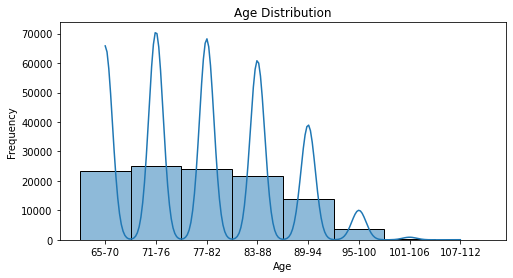

In [28]:
plt.figure(figsize=(8, 4))
sns.histplot(df['age_group'], bins=20, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


In this analysis, it becomes evident that the age distribution within the elderly population skewed toward individuals aged between 71 and 82, indicating that a significant proportion of the elderly population falls within this specific range.

#### GENDER DISTRIBUTION

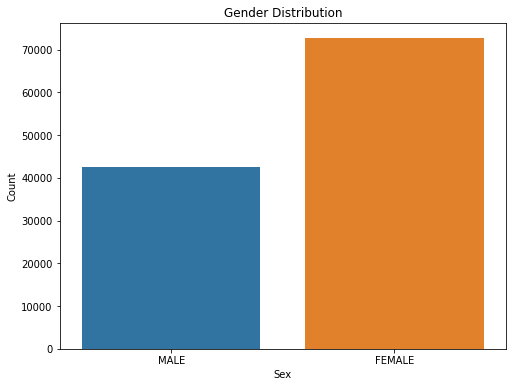

In [29]:
plt.figure(figsize=(8, 6))
sns.countplot(df, x='sex')
plt.title('Gender Distribution')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()


There is a higher proportion of females in this dataset.

#### RACE DISTRIBUTION

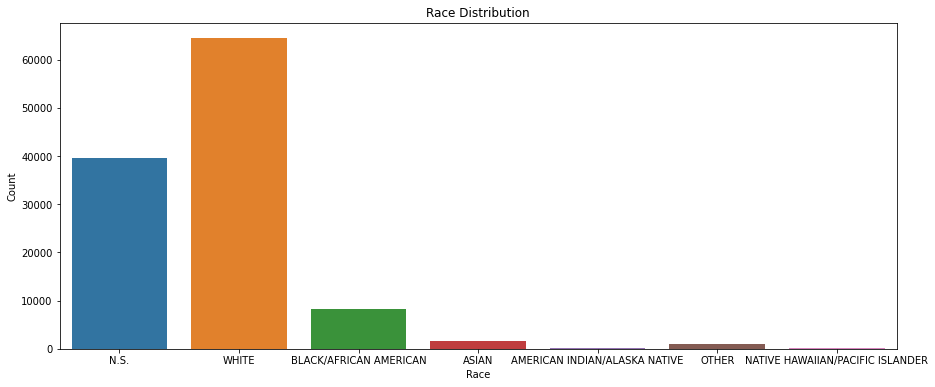

In [30]:
plt.figure(figsize=(15, 6))
sns.countplot(df, x='race')
plt.title('Race Distribution')
plt.xlabel('Race')
plt.ylabel('Count')
plt.show()


There are higher proportion of whites followed by Nova Scotia in this dataset.

#### DIAGNOSIS DISTRIBUTION

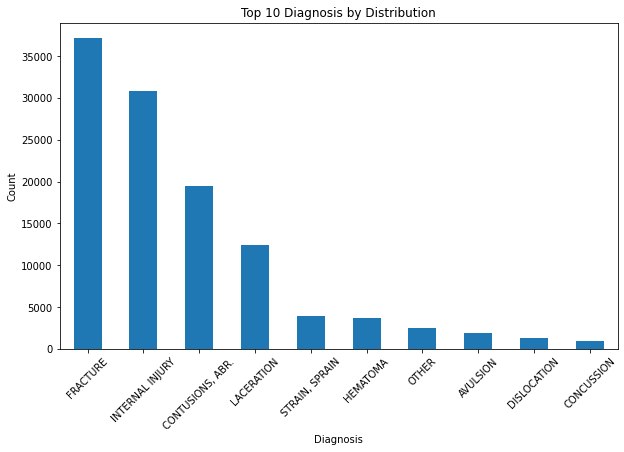

In [31]:
# Get the top 10 diagnosis 
top_10_diagnosis = df['diagnosis'].value_counts().head(10)

# Create a bar chart
plt.figure(figsize=(10, 6))
top_10_diagnosis.plot(kind='bar')
plt.title('Top 10 Diagnosis by Distribution')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.show()


These are the top 10 most frequently occurring diagnosis in this dataset, revealing the primary health conditions experienced by older individuals when they fall.

#### BODY PARTS DISTRIBUTION

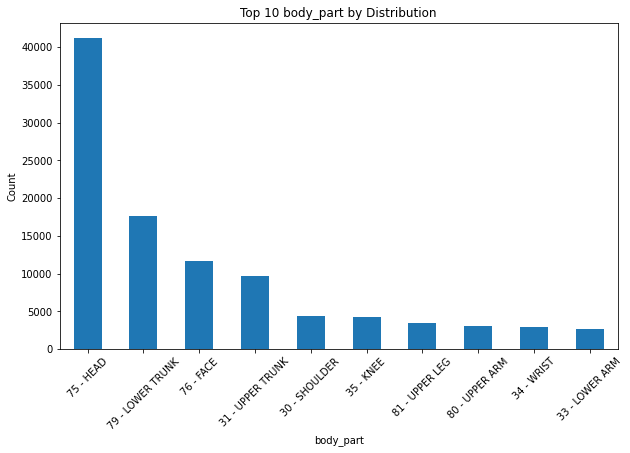

In [32]:
# Get the top 10 body parts affected by fall
top_10_body_part = df['body_part'].value_counts().head(10)

# Create a bar chart
plt.figure(figsize=(10, 6))
top_10_body_part.plot(kind='bar')
plt.title('Top 10 body_part by Distribution')
plt.xlabel('body_part')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.show()

When older individuals fall, these body parts are more susceptible to being affected.

### BIVARIATE ANALYSIS

Bivariate analysis refers to the statistical analysis or examination of the relationship or interactions between two variables or factors to understand their correlation, association, or dependencies.

### Demographic Factors:

##### AGE vs DIAGNOSIS

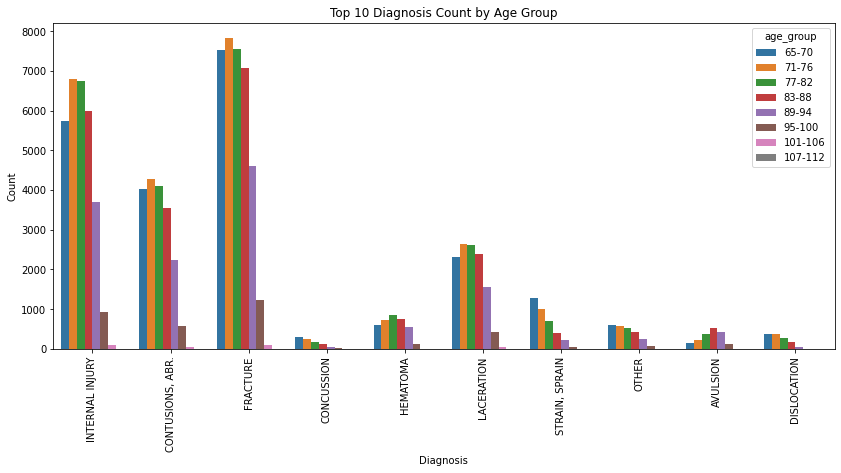

In [33]:
top_10_diagnosis = df['diagnosis'].value_counts().head(10).index
df_filtered = df[df['diagnosis'].isin(top_10_diagnosis)]
plt.figure(figsize=(14, 6))
sns.countplot(data=df_filtered, x='diagnosis', hue='age_group')
plt.title('Top 10 Diagnosis Count by Age Group')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

## HYPOTHESIS

### Age-Related Injury Trends: 

The data reveals clear age-related patterns in the types of injuries diagnosed after falls. As individuals advance in age, they exhibit distinct injury patterns, highlighting the importance of age as a risk factor for certain types of injuries.

Increased Risk of Internal Injuries (Ages 71-82): The finding that people between the ages of 71 and 82 are more frequently diagnosed with internal injuries following falls suggests that this age group may be particularly susceptible to injuries affecting internal organs. This vulnerability might be linked to age-related physiological changes or underlying health conditions.

Contusions and Auditory Brainstem Response (ABR) in Older Age Groups (Ages 65-82): The higher incidence of contusions (bruises) and the presence of auditory brainstem response (ABR) diagnoses within the age range of 65 to 82 indicate that falls in this age group not only result in physical injuries but may also have neurological or auditory implications. This finding underscores the need for a holistic assessment of falls in older adults.

Elevated Fracture Rates (Ages 65-88): The significant prevalence of fractures among individuals aged 65 to 88, with a notably higher rate, underscores the heightened risk of bone fractures in older age. This increased susceptibility might be attributed to factors such as reduced bone density and diminished musculoskeletal strength, which amplify the risk of fractures during falls.

In [ ]:
df.loc[0, 'diagnosis']

#### SEX VS DIAGNOSIS

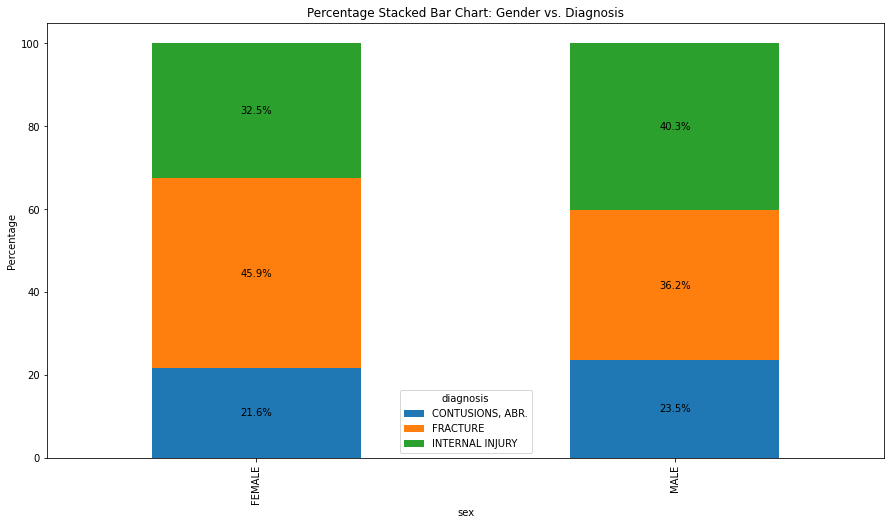

In [35]:
it = df[(df['diagnosis'] == 'INTERNAL INJURY') | (df['diagnosis'] == 'CONTUSIONS, ABR.') | (df['diagnosis'] == 'FRACTURE')]

# Calculate the proportions of each diagnosis by gender
diagnosis_proportions = it.groupby(['sex', 'diagnosis']).size() / it.groupby('sex').size()

# Reset the index for the proportions
diagnosis_proportions = diagnosis_proportions.reset_index(name='Proportion')

# Pivot the data to create a percentage stacked bar chart
pivot_table = diagnosis_proportions.pivot(index='sex', columns='diagnosis', values='Proportion')

# Normalize the data to percentages (multiply by 100)
pivot_table *= 100


# Create the percentage stacked bar chart
ax = pivot_table.plot(kind='bar', stacked=True, figsize=(15, 8))


plt.xlabel('sex')
plt.ylabel('Percentage')
plt.title('Percentage Stacked Bar Chart: Gender vs. Diagnosis')

# Add data labels to each bar segment
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.1f}%', (x + width / 2, y + height / 2), ha='center', va='center')


plt.show()


## HYPOTHESIS

### Gender-Specific Injury Patterns:

The data reveals gender-specific patterns in the types of injuries diagnosed after falls. These differences highlight the importance of considering gender as a factor in understanding and addressing specific health outcomes.

Higher Incidence of Internal Injury in Males: The higher occurrence of internal injury diagnoses in males suggests that men may be more susceptible to injuries affecting internal organs following falls. This finding may be indicative of gender-related physiological differences or variations in injury mechanisms.

Contusion and Auditory Brainstem Response (ABR) in Males: The prevalence of contusion and auditory brainstem response (ABR) diagnoses in males implies that men are more likely to experience bruises or minor injuries and may also be at greater risk of auditory or neurological issues following falls.

Fractures More Common in Females: The observation that fractures are diagnosed more frequently in females suggests that women may face a higher risk of bone fractures during falls. This could be influenced by factors such as bone density, physical activity, or age-related changes affecting bone health.


In [ ]:
df.loc[0, 'diagnosis']

#### RACE VS DIAGNOSIS

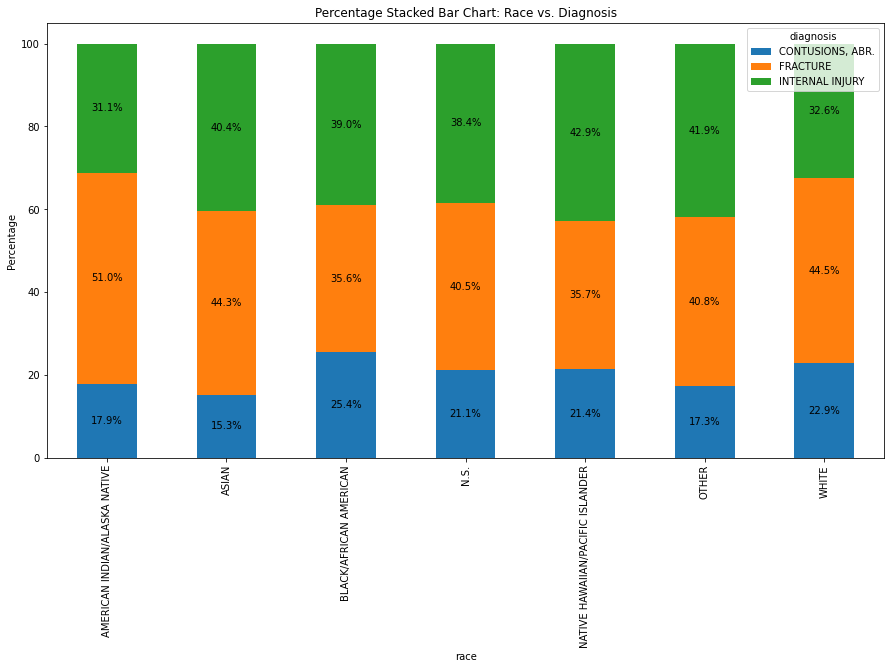

In [36]:
it = df[(df['diagnosis'] == 'INTERNAL INJURY') | (df['diagnosis'] == 'CONTUSIONS, ABR.') | (df['diagnosis'] == 'FRACTURE')]


# Calculate the proportions of each diagnosis by race
diagnosis_proportions = it.groupby(['race', 'diagnosis']).size() / it.groupby('race').size()

# Reset the index for the proportions
diagnosis_proportions = diagnosis_proportions.reset_index(name='Proportion')

# Pivot the data to create a percentage stacked bar chart
pivot_table = diagnosis_proportions.pivot(index='race', columns='diagnosis', values='Proportion')

# Normalize the data to percentages (multiply by 100)
pivot_table *= 100

# Create the percentage stacked bar chart
ax = pivot_table.plot(kind='bar', stacked=True, figsize=(15, 8))

# Add labels and a title
plt.xlabel('race')
plt.ylabel('Percentage')
plt.title('Percentage Stacked Bar Chart: Race vs. Diagnosis')

# Add data labels to each bar segment
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.1f}%', (x + width / 2, y + height / 2), ha='center', va='center')

plt.show()

## HYPOTHESIS

### Racial Disparities in Diagnosis Patterns: 

The data indicates that there are disparities in the types of diagnoses individuals receive following falls among different racial groups. These disparities may reflect variations in healthcare access, socioeconomic factors, or underlying health conditions within these populations.

Higher Occurrence of Internal Injuries in Native Hawaiian/Pacific Islander: The higher incidence of internal injury diagnoses in the Native Hawaiian/Pacific Islander group suggests that individuals from this racial background may be more susceptible to injuries affecting internal organs after falling. Further research is needed to understand the specific factors contributing to this pattern.

Contusions and Auditory Brainstem Response (ABR) in Black/African American: The prevalence of contusion and auditory brainstem response (ABR) diagnoses in the Black/African American population may indicate that falls in this racial group not only result in physical injuries (contusions) but may also have neurological or auditory implications (ABR). This finding underscores the need for comprehensive assessments and care for fall-related injuries in this demographic.

Fractures More Common in American Indian/Alaska Native: The observation that fractures are diagnosed more frequently in the American Indian/Alaska Native population suggests that individuals from this racial background may be at a higher risk of bone fractures following falls. Factors contributing to this risk may include variations in bone health, activity levels, or other sociocultural factors.

### ALCOHOL VS DIAGNOSIS

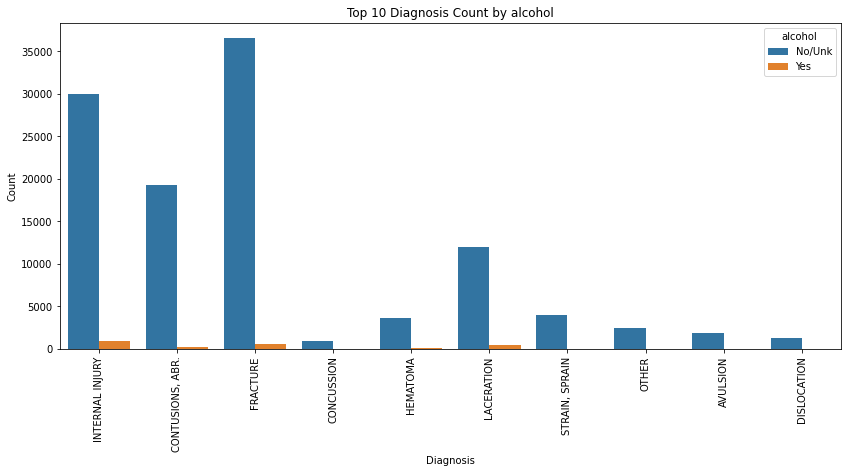

In [37]:
top_10_diagnosis = df['diagnosis'].value_counts().head(10).index
df_filtered = df[df['diagnosis'].isin(top_10_diagnosis)]
plt.figure(figsize=(14, 6))
sns.countplot(data=df_filtered, x='diagnosis', hue='alcohol')
plt.title('Top 10 Diagnosis Count by alcohol')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

most of the falls are obviously not caused by alcohol

### DRUGS VS DIAGNOSIS

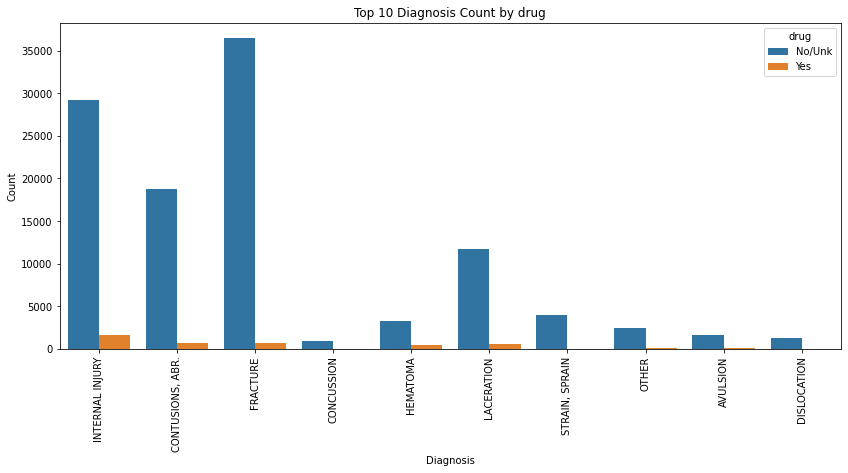

In [38]:
top_10_diagnosis = df['diagnosis'].value_counts().head(10).index
df_filtered = df[df['diagnosis'].isin(top_10_diagnosis)]
plt.figure(figsize=(14, 6))
sns.countplot(data=df_filtered, x='diagnosis', hue='drug')
plt.title('Top 10 Diagnosis Count by drug')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

Most of the falls are not caused by Drugs as well

### Environmental Factors:

##### Does the location or environment where falls occur impact the likelihood of injury?

### LOCATION VS DIAGNOSIS

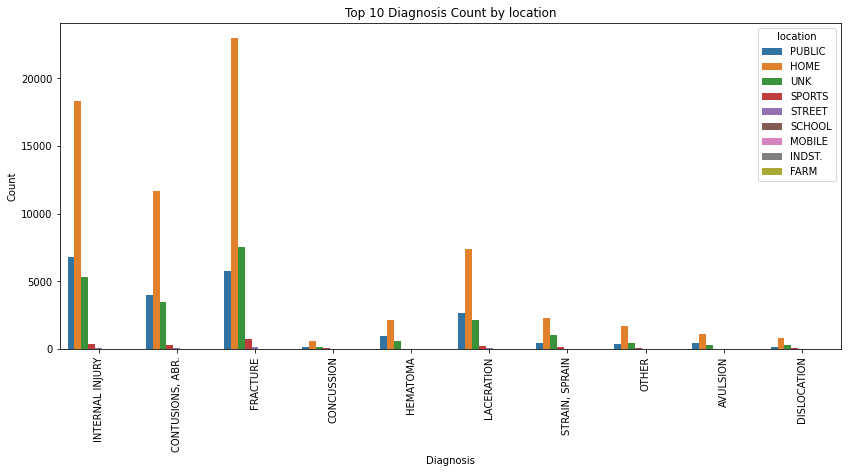

In [39]:
top_10_diagnosis = df['diagnosis'].value_counts().head(10).index
df_filtered = df[df['diagnosis'].isin(top_10_diagnosis)]
plt.figure(figsize=(14, 6))
sns.countplot(data=df_filtered, x='diagnosis', hue='location')
plt.title('Top 10 Diagnosis Count by location')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

## HYPOTHESIS

The observation that most falls occur at home, unknown locations, and in public areas provides valuable insights into fall prevention and safety measures. Here are insights and potential solutions based on this observation:

#### Insights:

Home as a Common Location: The fact that a significant number of falls occur at home underscores the importance of home safety for individuals of all ages, particularly for older adults who may spend a substantial amount of time at home.

Unknown Locations: The "unknown location" category may indicate that some falls happen in unmonitored or less-traveled areas, making it challenging to identify and respond to these incidents promptly.

Public Spaces: Falls in public areas highlight the need for public safety measures and awareness campaigns to reduce the risk of falls in crowded places.

#### Solutions:

Home Safety Assessments: Encourage home safety assessments, particularly for older adults, to identify and address potential fall hazards at home. This may include removing tripping hazards, improving lighting, installing handrails, and making bathrooms more accessible.

### LOCATION VS DISPOSITION 

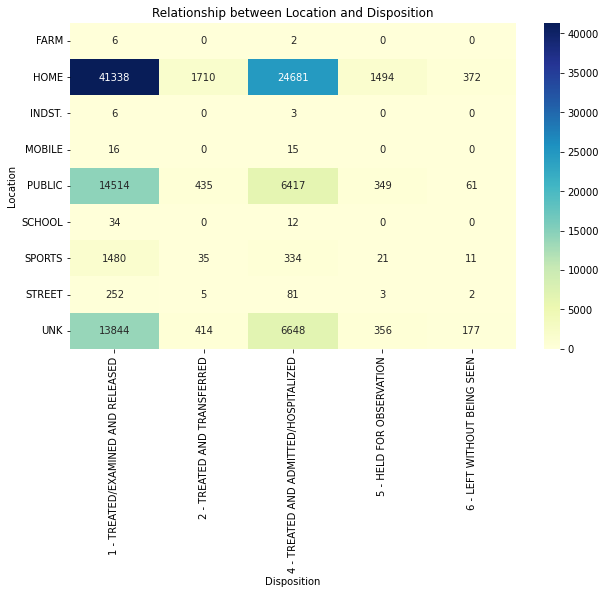

In [40]:
location_disposition_cross_tab = pd.crosstab(df['location'], df['disposition'])
# Visualize the relationship between location and disposition using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(location_disposition_cross_tab, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Relationship between Location and Disposition')
plt.xlabel('Disposition')
plt.ylabel('Location')
plt.show()



### Severity and Treatment Outcomes:

Falls at home are more common but result in a mix of treatment outcomes: a significant number of individuals are treated and released, while a substantial number require hospitalization,but the *treated and transferred* and *left wothout being seen* caught our attention.. why??


### TREATED AND TRANSFERRED


finding that some individuals were "treated and transferred" can have several implications and interpretations. Here are some possible explanations:

1. **Severity of Condition**: Individuals who were "treated and transferred" may have had medical conditions or injuries that required immediate treatment in one healthcare facility but needed specialized care or further evaluation at another facility. This suggests that their conditions were of a moderate to high severity.

2. **Availability of Specialized Services**: The initial healthcare facility where they were treated might not have had the specialized equipment, expertise, or resources needed to fully address their medical condition. Therefore, they were transferred to a different facility where such resources were available.

3. **Hospital-to-Hospital Transfer**: It could mean that patients were initially brought to a general hospital, but their condition required treatment at a specialized hospital or trauma center. These transfers are common for cases like severe trauma, stroke, or cardiac events.

4. **Interfacility Transfer**: In some cases, patients might be transferred from one healthcare facility to another within a healthcare network for continuity of care or access to specialized services like surgery or intensive care.

5. **Insurance or Coverage Considerations**: The choice to "treat and transfer" might also be influenced by insurance coverage or the patient's financial situation. Some treatments might be initiated at one facility to stabilize the patient before they are transferred to a different facility that is in-network or covered by their insurance.

Incorporating this insight into this analysis allows for a more comprehensive understanding of the healthcare landscape, patient outcomes, and the factors that influence medical decision-making. It helps to assess the effectiveness and efficiency of the healthcare system and can guide improvements in patient care and resource allocation.


### LEFT WITHOUT BEING SEEN

When conducting a bivariate analysis of health data columns like "disposition" and "diagnosis" and finding that some individuals "left without being seen," it can have several possible interpretations and implications:

1. **Patient Discontent**: Patients may have left without being seen due to dissatisfaction with the healthcare facility, long wait times, or perceived poor quality of care. This could indicate issues with patient experience and satisfaction.

2. **Walk-Outs**: "Left without being seen" often refers to patients who arrived at a healthcare facility (such as an emergency department) but left before receiving any medical evaluation or treatment. This might happen if they felt their condition improved, they couldn't wait any longer, or they thought their condition was not serious.

3. **Resource Constraints**: Healthcare facilities, particularly emergency departments, may face resource constraints, leading to long wait times and the inability to see all patients promptly. Some patients may leave due to these resource limitations.

4. **Urgency Assessment**: Patients who "left without being seen" may have initially perceived their condition as urgent but later reconsidered or received advice from others that their condition was not severe. This indicates changes in the perceived urgency of their health issues.


 **Legal and Ethical Considerations**: Healthcare professionals have legal and ethical obligations to ensure that patients receive appropriate care. "Left without being seen" cases raise questions about whether these obligations were met.

To fully understand the meaning and implications of patients leaving without being seen, it's essential to investigate the specific circumstances, including the diagnosis or presenting complaints of these patients, the timing of their departure, and any factors contributing to their decision. Such an analysis can help healthcare facilities identify opportunities for improvement in patient care, satisfaction, and operational efficiency. Additionally, it can lead to strategies for reducing patient walk-outs and ensuring that patients receive the care they need in a timely and appropriate manner.


The top reason is PATIENT DISCONTENT
Patient discontent in the healthcare sector can have significant implications for both patients and healthcare providers. Addressing patient discontent is crucial to improving the quality of care, patient experience, and overall healthcare outcomes. Here are some implications of patient discontent and strategies to tackle it:

**Implications of Patient Discontent:**

1. **Negative Patient Outcomes**: Discontented patients may delay seeking medical care, follow-up appointments, or necessary treatments, which can lead to worsened health conditions and outcomes.

2. **Reduced Trust**: Dissatisfied patients may lose trust in healthcare providers and institutions, making them less likely to adhere to medical advice or recommendations.

3. **Impact on Reputation**: Negative patient experiences can damage the reputation of healthcare facilities and healthcare providers, affecting their ability to attract and retain patients.

4. **Decreased Patient Compliance**: Discontent can result in decreased patient compliance with prescribed medications, treatment plans, and lifestyle recommendations.

5. **Litigation Risk**: Unhappy patients are more likely to consider legal action in cases of perceived medical malpractice or negligence, leading to increased legal risks for healthcare providers.

6. **Decreased Patient Retention**: Patients who are dissatisfied with their healthcare experience may seek care elsewhere, leading to a loss of patient retention and revenue for healthcare facilities.

**Strategies to Tackle Patient Discontent:**

1. **Improve Communication**: Effective communication between healthcare providers and patients is essential. Encourage open and empathetic communication, active listening, and clear explanations of diagnoses, treatment options, and expectations.

2. **Enhance Patient-Centered Care**: Shift the focus to patient-centered care, where patients are actively involved in decision-making regarding their health and treatment plans. Involve patients in care discussions and respect their preferences.

3. **Reduce Wait Times**: Implement strategies to reduce waiting times in healthcare facilities, such as appointment scheduling improvements, efficient patient flow, and optimized resource allocation.

4. **Enhance Staff Training**: Provide healthcare staff with training in patient communication, empathy, and cultural competence to ensure positive patient interactions.

5. **Quality Improvement Initiatives**: Continuously monitor and assess the quality of care through patient satisfaction surveys, feedback mechanisms, and performance evaluations. Use data to identify areas for improvement.

6. **Patient Advocacy Programs**: Establish patient advocacy programs to assist patients in navigating the healthcare system, addressing concerns, and ensuring their needs are met.

7. **Transparency**: Be transparent about healthcare costs, treatment options, and potential risks. Patients appreciate transparency in billing and treatment decisions.

8. **Complaint Resolution**: Develop clear and efficient mechanisms for addressing patient complaints and grievances. Ensure that patients know how to voice their concerns and that their feedback is taken seriously.

9. **Staff Well-Being**: Recognize that healthcare staff well-being is closely tied to patient satisfaction. Support and engage healthcare providers to prevent burnout and maintain a positive work environment.

10. **Technology Integration**: Leverage technology to improve patient experiences, such as online appointment scheduling, telehealth options, and electronic health records for easy access to medical information.

11. **Cultural Competency**: Train healthcare providers to be culturally competent and sensitive to the diverse needs and backgrounds of patients.

12. **Patient Education**: Empower patients with information about their health conditions and treatment plans. Ensure they understand their role in managing their health.

13. **Continuous Feedback Loop**: Establish a continuous feedback loop with patients to gather input and make improvements based on their suggestions and concerns.

Addressing patient discontent is an ongoing process that requires a commitment to patient-centered care, quality improvement, and a culture of empathy and responsiveness within the healthcare sector. By taking proactive steps to enhance patient satisfaction and address patient concerns, healthcare providers and institutions can improve patient outcomes and maintain their reputation.

## To identify the common circumstances or activities during which falls occur among older adults 

In [45]:
df['narrative'] = df['narrative'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')

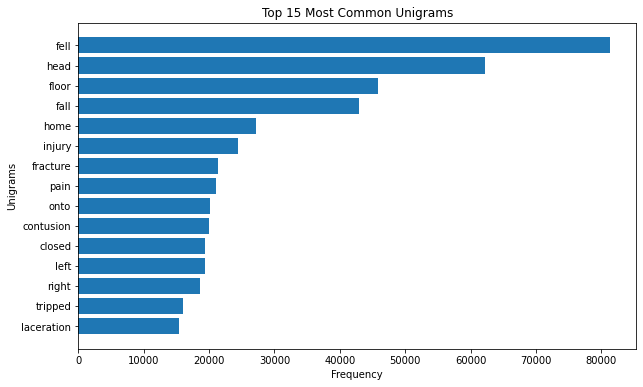

In [46]:
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter

sentences = df['narrative'].dropna().str.replace(',', '').str.replace(':', '').str.replace('.', '')

# Tokenize the sentences into unigrams
unigrams = [word_tokenize(sentence) for sentence in sentences if len(sentence) >= 4]

# Flatten the list of unigrams
unigrams = [word for sublist in unigrams for word in sublist if len(word) >= 4]

# Count the frequency of each unigram
unigram_counts = Counter(unigrams)

#Get the top 15 most common unigrams and their counts
top_n = 15
most_common_unigrams = unigram_counts.most_common(top_n)
common_unigrams, counts = zip(*most_common_unigrams)

# Create a bar chart to visualize unigram frequencies
plt.figure(figsize=(10, 6))
plt.barh(common_unigrams, counts)
plt.xlabel('Frequency')
plt.ylabel('Unigrams')
plt.title(f'Top {top_n} Most Common Unigrams')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most common at the top
plt.show()


## BIGRAMS

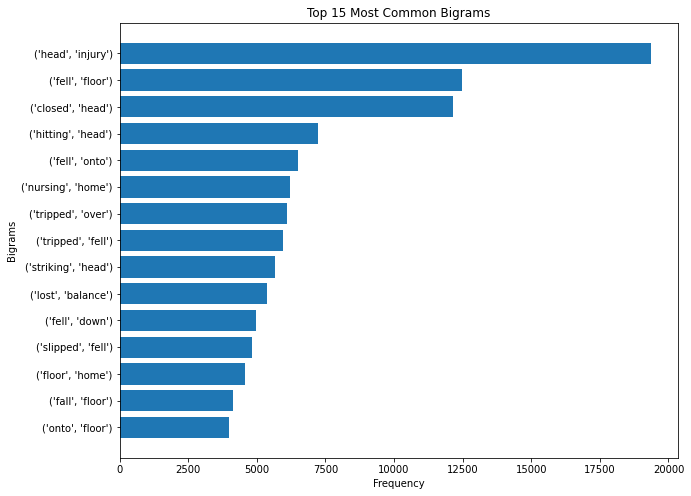

In [47]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from nltk import bigrams
df['narrative'] = df['narrative'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')

sentences = df['narrative'].dropna().str.replace(',', '').str.replace(':', '').str.replace('.', '')

# Initialize NLTK's stop words
stop_words = set(stopwords.words('english'))

# Initialize a list to store preprocessed bigrams
preprocessed_bigrams = []

for sentence in sentences:
    # Tokenize the sentence
    tokens = word_tokenize(sentence)
   
    
    # Convert to lowercase, remove punctuation, and remove stop words
    clean_tokens = [word.lower() for word in tokens if word.isalpha() and len(word) >= 4  not in stop_words]
    
    # Create bigrams from the clean tokens
    bigrams_list = list(bigrams(clean_tokens))
    
    # Append the preprocessed bigrams to the list
    preprocessed_bigrams.extend(bigrams_list)

# Count the frequency of each bigram
bigram_counts = Counter(preprocessed_bigrams)

# Get the top 15 most common bigrams and their counts
top_15_bigrams = bigram_counts.most_common(15)
bigram_labels, bigram_counts = zip(*top_15_bigrams)

# Create a bar chart to visualize bigram frequencies
plt.figure(figsize=(10, 8))
plt.barh(range(len(bigram_labels)), bigram_counts)
plt.yticks(range(len(bigram_labels)), bigram_labels)
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.title('Top 15 Most Common Bigrams')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most common at the top
plt.show()


### The bigrams extracted provide insights into the reasons older adults fall and suggest potential solutions for fall prevention. Let's analyze each bigram:

1. **Head Injury**: The presence of "head injury" indicates that head injuries are a significant outcome of falls among older adults. It's essential to focus on strategies to prevent head injuries, such as using protective headgear and implementing fall prevention programs.

2. **Fell Floor**: "Fell floor" suggests that falls often result in individuals landing on the floor. This emphasizes the importance of strategies to minimize the impact of falls, including improving flooring materials to reduce injury risk.

3. **Closed Head**: "Closed head" could refer to injuries where the skull is not fractured but may still result in concussions or other head injuries. Preventive measures may include education on recognizing the signs of head injuries and seeking medical attention.

4. **Hitting Head**: Falls that lead to "hitting head" indicate a potential problem with balance or coordination. Solutions may involve balance exercises, regular vision check-ups, and environmental modifications to reduce hazards.

5. **Nursing Home**: The mention of "nursing home" suggests that falls occur in care facilities. Solutions may involve improved staff training, fall risk assessments, and environmental modifications in nursing homes.

6. **Tripped Over**: "Tripped over" highlights the role of tripping hazards in falls. Reducing tripping hazards, such as clutter and loose rugs, can help prevent falls.

7. **Striking Head**: Similar to "hitting head," this bigram points to falls leading to head injuries. Strategies to reduce head injuries are relevant here.

8. **Lost Balance**: The phrase "lost balance" indicates that balance issues may contribute to falls. Balance training exercises and medical evaluations to identify underlying causes can be beneficial.

9. **Fell Down**: "Fell down" is a straightforward representation of falls. Fall prevention strategies should be implemented broadly, including home safety measures and regular exercise.

10. **Floor Home**: "Floor home" suggests that falls often occur at home. Home safety assessments and modifications are essential to reduce fall risks.

Based on these insights, here are some potential solutions for fall prevention among older adults:

- **Fall Risk Assessments**: Conduct regular fall risk assessments for older adults, taking into account their health conditions, mobility, and living environment.

- **Home Safety Modifications**: Promote home safety assessments and modifications, such as installing handrails, improving lighting, and removing tripping hazards.

- **Balance and Strength Training**: Encourage older adults to engage in balance and strength training exercises to improve their physical stability and reduce the risk of falling.

- **Medication Management**: Review and manage medications that may cause dizziness or affect balance, consulting with healthcare professionals as needed.

- **Use of Mobility Aids**: Provide and educate older adults on the appropriate use of mobility aids such as walkers or canes.

- **Regular Health Checkups**: Encourage older adults to have regular checkups with healthcare providers to address any underlying health issues that may contribute to falls.

- **Educational Programs**: Offer educational programs to raise awareness about fall prevention, including information on recognizing fall risks and taking preventive measures.

- **Environmental Modifications in Nursing Homes**: Improve the safety of nursing homes by implementing environmental modifications and staff training programs.

- **Protective Headgear**: For older adults at risk of head injuries due to falls, consider the use of protective headgear, such as helmets or head protection.

- **Regular Vision Exams**: Encourage older adults to have regular vision exams to ensure proper vision, which is crucial for balance and coordination.

Implementing a combination of these solutions tailored to individual needs and circumstances can significantly reduce the risk of falls among older adults and enhance their overall safety and well-being. Additionally, fostering a supportive and vigilant community or caregiver network can further contribute to fall prevention.